In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pwd

'/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/train'

In [ ]:
ls

^C


In [ ]:
cd /content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/train

/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/train


In [2]:
# Install required libraries
!pip install pyunpack
!pip install patool

from pyunpack import Archive
from google.colab import drive
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.0 MB/s eta 0:00:00


In [3]:
# Function to read annotations

def read_annotations(xml_file, folder_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(folder_path, filename)
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)
    image = cv2.imread(image_path)

    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymin = int(obj.find('bndbox/ymin').text)
        ymax = int(obj.find('bndbox/ymax').text)

        annotations.append({
            'name': name,
            'bbox': (xmin, ymin, xmax, ymax)
        })

    return {
        'filename': filename,
        'image_path': image_path,
        'width': width,
        'height': height,
        'depth': depth,
        'image': image,
        'annotations': annotations
    }

# Function to preprocess images and annotations for training

def preprocess_data(image, annotations, width,height,input_shape=(224, 224)):
    # Resize the image
    image = cv2.resize(image, input_shape)

    # Normalize pixel values to be in the range [0, 1]
    image = image / 255.0

    # Resize and normalize bounding box coordinates
    processed_annotations = []
    for annotation in annotations:
        bbox = annotation['bbox']
        xmin, ymin, xmax, ymax = bbox

        # Scale bounding box coordinates based on resizing factor
        x_scale = input_shape[1] / (width*224)
        y_scale = input_shape[0] / (height*224)

        processed_bbox = (
            float(xmin * x_scale),
            float(ymin * y_scale),
            float(xmax * x_scale),
            float(ymax * y_scale)
        )

        processed_annotations.append({
            'name': annotation['name'],
            'bbox': processed_bbox
        })
    # print(processed_bbox)
    return image, processed_annotations

# Load and preprocess the dataset

def load_dataset(folder_path, max_images):
    dataset = []
    image_count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            xml_file_path = os.path.join(folder_path, filename)
            data = read_annotations(xml_file_path, folder_path)

            # Preprocess the image and annotations
            processed_image, processed_annotations = preprocess_data(data['image'], data['annotations'],data['width'],data['height'])

            dataset.append({
                'image': processed_image,
                'annotations': processed_annotations
            })

            image_count += 1
            if image_count >= max_images:
                break

    return dataset



In [4]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [5]:
# Specify the folder containing the images and XML files
folder_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/lim_train'

# Load and preprocess the dataset
dataset = load_dataset(folder_path, max_images=3000)
unique_categories = set()
for example in dataset:
    for annotation in example['annotations']:
        unique_categories.add(annotation['name'])

# Add a new class for "no object"
unique_categories.add('no_object')

unique_category_to_index = {category: idx for idx, category in enumerate(unique_categories)}

# Create TensorFlow Dataset with multiple bounding boxes per image
data = np.array([example['image'] for example in dataset])

# Assuming you have already initialized targets like this:
num_images = len(dataset)
num_annotations_per_image = 5
num_categories = len(unique_categories)

targets = {
    'labels': np.zeros((num_images, num_annotations_per_image, num_categories), dtype=np.float64),
    'boxes': np.zeros((num_images, num_annotations_per_image, 4), dtype=np.float64)
}

for i, example in enumerate(dataset):
    image_id = np.array([i])
    for j, anno in enumerate(example['annotations']):
        # print(j)
        if j < num_annotations_per_image:
            # Extract bounding box coordinates
            xmin, ymin, xmax, ymax = anno['bbox']
            category_label = unique_category_to_index[anno['name']]

            # Store bounding box coordinates and category label in targets
            targets['boxes'][i, j, :] = [xmin, ymin, xmax, ymax]

            # Convert category label to one-hot encoding
            one_hot_encoding = np.zeros(num_categories, dtype=np.float64)
            one_hot_encoding[category_label] = 1.0
            targets['labels'][i, j, :] = one_hot_encoding

    # Add "no object" class for remaining slots
    for j in range(len(example['annotations']), num_annotations_per_image):
        targets['labels'][i, j, unique_category_to_index['no_object']] = 1.0

# Create TensorFlow Dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    ({'efficientnet-b0_input': data},
     {'classification': targets['labels'], 'reshape_bbox': targets['boxes']}))
print(len(train_ds))

979


In [6]:
folder_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/valid'

# Load and preprocess the dataset
dataset = load_dataset(folder_path, max_images=450)
unique_categories = set()
for example in dataset:
    for annotation in example['annotations']:
        unique_categories.add(annotation['name'])

# Add a new class for "no object"
unique_categories.add('no_object')

unique_category_to_index = {category: idx for idx, category in enumerate(unique_categories)}

# Create TensorFlow Dataset with multiple bounding boxes per image
data = np.array([example['image'] for example in dataset])

# Assuming you have already initialized targets like this:
num_images = len(dataset)
num_annotations_per_image = 5
num_categories = len(unique_categories)

targets = {
    'labels': np.zeros((num_images, num_annotations_per_image, num_categories), dtype=np.float64),
    'boxes': np.zeros((num_images, num_annotations_per_image, 4), dtype=np.float64)
}

for i, example in enumerate(dataset):
    image_id = np.array([i])
    for j, anno in enumerate(example['annotations']):
        # print(j)
        if j < num_annotations_per_image:
            # Extract bounding box coordinates
            xmin, ymin, xmax, ymax = anno['bbox']
            category_label = unique_category_to_index[anno['name']]

            # Store bounding box coordinates and category label in targets
            targets['boxes'][i, j, :] = [xmin, ymin, xmax, ymax]

            # Convert category label to one-hot encoding
            one_hot_encoding = np.zeros(num_categories, dtype=np.float64)
            one_hot_encoding[category_label] = 1.0
            targets['labels'][i, j, :] = one_hot_encoding

    # Add "no object" class for remaining slots
    for j in range(len(example['annotations']), num_annotations_per_image):
        targets['labels'][i, j, unique_category_to_index['no_object']] = 1.0

# Create TensorFlow Dataset
valid_ds = tf.data.Dataset.from_tensor_slices(
    ({'efficientnet-b0_input': data},
     {'classification': targets['labels'], 'reshape_bbox': targets['boxes']}))
# print(targets['labels'])
print(len(valid_ds))

450


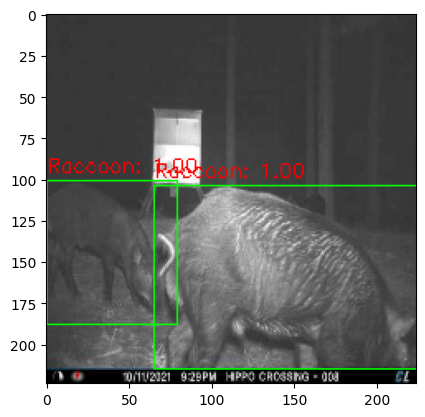

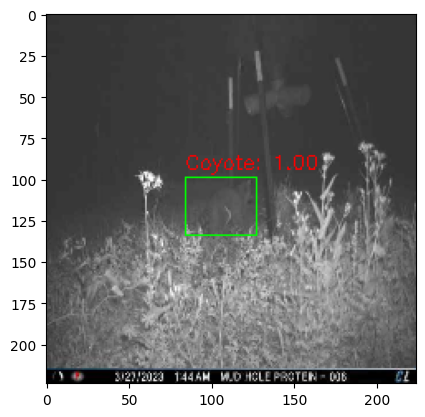

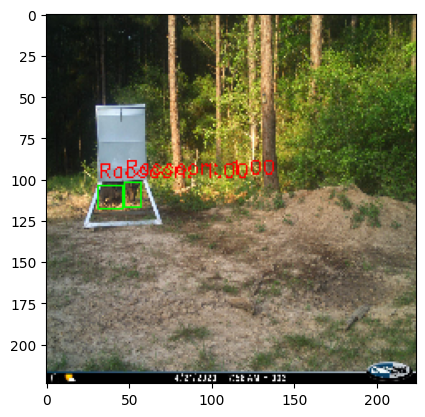

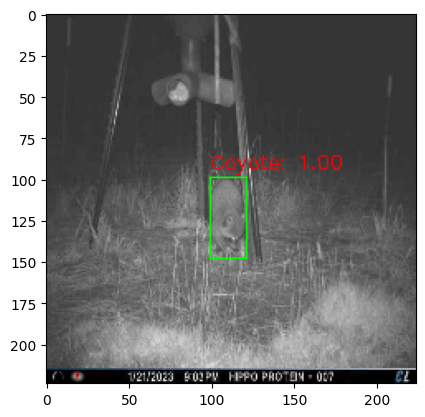

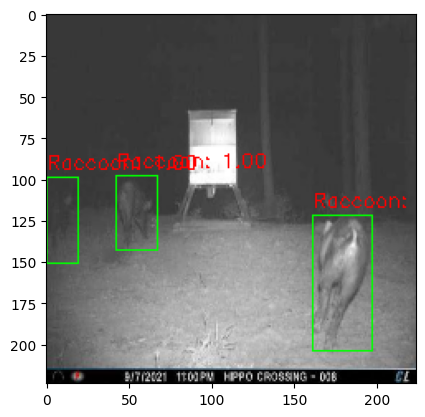

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Mapping from class index to class name
class_index_to_name = {0:'Coyote' , 1:'Deer' , 2: 'Hog', 3:'Rabbit' , 4: 'Raccoon'}

# Function to visualize images with bounding boxes
def visualize_images_with_boxes(dataset, num_images=5):
    # Select a few images from the dataset
    sample_dataset = dataset.take(num_images)

    for data in sample_dataset:
        image = data[0]['efficientnet-b0_input'].numpy()
        boxes = data[1]['reshape_bbox'].numpy()
        classification = data[1]['classification'].numpy()

        # Convert image to uint8 and BGR format
        image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

        # Plot bounding boxes using OpenCV
        for i, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = box
            xmin = xmin * 224
            ymin = ymin * 224
            xmax = xmax * 224
            ymax = ymax * 224

            # Draw bounding box
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 1)

            # Draw class name and probability
            class_index = np.argmax(classification[i])
            class_name = class_index_to_name.get(class_index, "Unknown")
            confidence = classification[i, class_index]

            text = f"{class_name}: {confidence:.2f}"
            cv2.putText(image, text, (int(xmin), int(ymin) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

        # Display the image with bounding boxes
        plt.imshow(image)
        plt.show()

# Call the function to visualize 5 images from the dataset
visualize_images_with_boxes(valid_ds, num_images=5)


In [ ]:
print(class_index_to_name.keys())


dict_keys([0, 1, 2, 3, 4])


In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
from efficientnet.tfkeras import EfficientNetB0  # Import EfficientNetB0

# using EfficientNetB0 as backbone for feature extraction
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freezing its layers
base_model.trainable = False

# Now designing our custom architecture
model = models.Sequential()

# Adding base model
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

# Adding dense layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.6))  # Increased dropout rate

# Two separate parallel branches for classification scores and bounding box predictions

# Classification branch
num_classes = 6  # Adjust based on the number of classes in your dataset
classification_branch = layers.Dense(5 * num_classes, activation='softmax', name='classification1')(model.layers[-1].output)
classification_reshaped = layers.Reshape((5, num_classes), name='classification')(classification_branch)

# Regression Branch for bounding box generation
bbox_branch = layers.Dense(5 * 4, activation='sigmoid', name='bounding_box')(model.layers[-1].output)
bbox_reshaped = layers.Reshape((5, 4), name='reshape_bbox')(bbox_branch)

# Model with both branches
model = models.Model(inputs=model.input, outputs=[classification_reshaped, bbox_reshaped])

# Print model summary
model.summary()


16804768/16804768 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 efficientnet-b0_input (Inp  [(None, 224, 224, 3)]        0         []                            
 utLayer)                                                                                         
                                                                                                  
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)           4049564   ['efficientnet-b0_input[0][0]'
 l)                                                                 ]                             
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['efficientnet-b0[0][0]']     
 GlobalAveragePooling2D)     

In [10]:
# Compile the model with categorical_crossentropy and mean squared error as the loss functions for classification and regression branches, respectively.
model.compile(optimizer='adam',
              loss={'classification': 'categorical_crossentropy', 'reshape_bbox': 'mse'},
              metrics={'classification': 'accuracy', 'reshape_bbox': 'mae'})

In [11]:
# Assuming train_ds is your existing dataset
batch_size = 32

# Batch the dataset
train_ds = train_ds.batch(batch_size)
valid_ds = valid_ds.batch(batch_size)

# Print the number of batches in the dataset
print(len(train_ds))
print(len(valid_ds))


31
15


In [12]:
history = model.fit(train_ds, epochs=250, validation_data=valid_ds)

Epoch 1/250
31/31 [==============================] - 19s 269ms/step - loss: 1.1752 - classification_loss: 0.9661 - reshape_bbox_loss: 0.2091 - classification_accuracy: 0.6942 - reshape_bbox_mae: 0.3752 - val_loss: 0.7291 - val_classification_loss: 0.6185 - val_reshape_bbox_loss: 0.1106 - val_classification_accuracy: 0.8067 - val_reshape_bbox_mae: 0.2675
Epoch 2/250
31/31 [==============================] - 4s 122ms/step - loss: 0.7242 - classification_loss: 0.5964 - reshape_bbox_loss: 0.1278 - classification_accuracy: 0.8188 - reshape_bbox_mae: 0.2646 - val_loss: 0.6111 - val_classification_loss: 0.5512 - val_reshape_bbox_loss: 0.0599 - val_classification_accuracy: 0.8240 - val_reshape_bbox_mae: 0.1878
Epoch 3/250
31/31 [==============================] - 4s 123ms/step - loss: 0.5944 - classification_loss: 0.5165 - reshape_bbox_loss: 0.0778 - classification_accuracy: 0.8447 - reshape_bbox_mae: 0.1965 - val_loss: 0.5743 - val_classification_loss: 0.5318 - val_reshape_bbox_loss: 0.0425 - v

In [13]:
# Save the model for future use
model.save('EfficientNet_Backbone_object_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


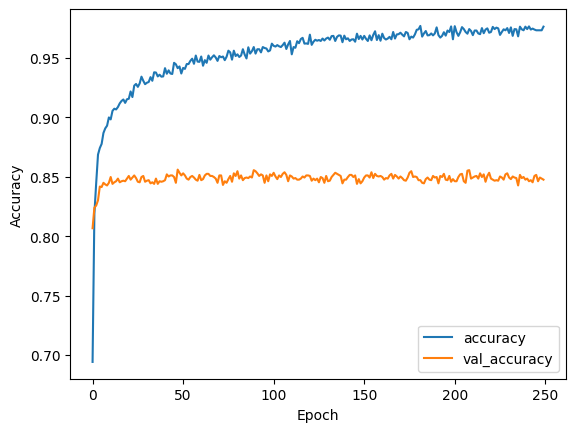

In [14]:
plt.plot(history.history['classification_accuracy'], label='accuracy')
plt.plot(history.history['val_classification_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

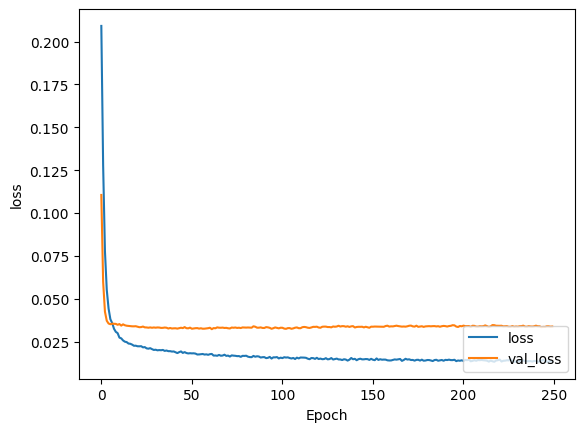

In [15]:
plt.plot(history.history['reshape_bbox_loss'], label='loss')
plt.plot(history.history['val_reshape_bbox_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [16]:
# Make predictions using the model
predictions = model.predict(valid_ds)

# Classification metrics
classification_predictions = predictions[0].reshape(-1, 5)
classification_targets = np.concatenate([y['classification'] for _, y in valid_ds], axis=0).reshape(-1, 5)
classification_targets = np.argmax(classification_targets, axis=-1)  # Convert one-hot encoding to class indices

print("Performance Metrics:")
print(classification_report(classification_targets, np.argmax(classification_predictions, axis=-1), zero_division=1))

# Bounding box metrics (IoU)
iou_predictions = predictions[1].reshape(-1, 4)
iou_targets = np.concatenate([y['reshape_bbox'] for _, y in valid_ds], axis=0).reshape(-1, 4)

# Compute IoU for each prediction
def calculate_iou(box1, box2):
    x1, y1, width1, height1 = box1
    x2, y2, width2, height2 = box2

    intersection_x = max(x1, x2)
    intersection_y = max(y1, y2)
    intersection_w = max(0, min(x1 + width1, x2 + width2) - intersection_x)
    intersection_h = max(0, min(y1 + height1, y2 + height2) - intersection_y)

    intersection_area = intersection_w * intersection_h
    union_area = (width1 * height1) + (width2 * height2) - intersection_area

    iou = intersection_area / union_area
    return iou

iou_scores = [calculate_iou(pred_box, target_box) for pred_box, target_box in zip(iou_predictions, iou_targets)]
average_iou = np.mean(iou_scores)

print(f"\nAverage IoU: {average_iou}")


15/15 [==============================] - 2s 66ms/step
Performance Metrics:
              precision    recall  f1-score   support

           0       0.89      0.58      0.70      1133
           1       0.74      0.96      0.83       500
           2       1.00      0.23      0.37        22
           3       0.58      0.86      0.69       506
           4       0.82      0.84      0.83       539

    accuracy                           0.75      2700
   macro avg       0.81      0.69      0.69      2700
weighted avg       0.79      0.75      0.75      2700


Average IoU: 0.07459021754917104


1/1 [==============================] - 3s 3s/step


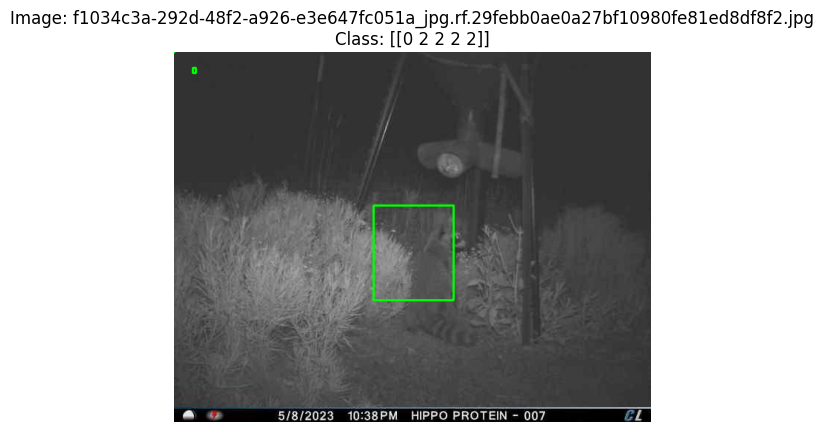

Error processing image cfdaac9a-a728-4414-8246-b37fcc4ce03d_jpg.rf.26a92446db286939dd2bc4b18402d10f.xml: cannot identify image file <_io.BytesIO object at 0x7ff105237a10>
1/1 [==============================] - 0s 26ms/step


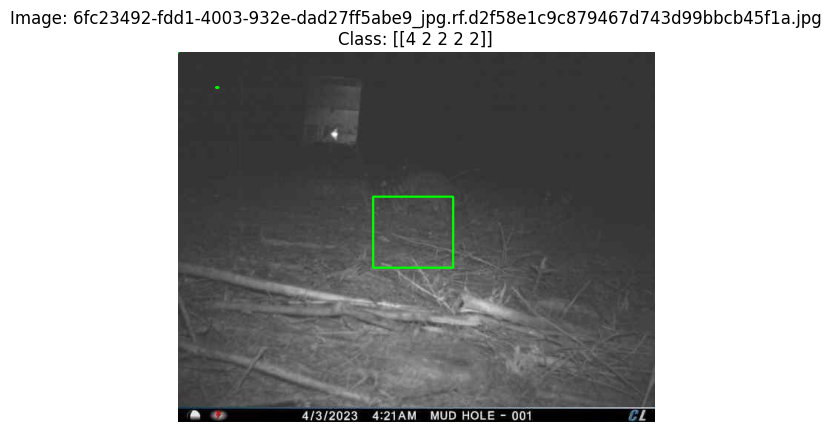

Error processing image 809799e4-2375-4f48-adb9-0fcc18294b60_jpg.rf.65326e5b025bdf3ea7b4973b3c41d20a.xml: cannot identify image file <_io.BytesIO object at 0x7ff106073790>
Error processing image d5e9e5d2-8c6d-43f6-96b1-b79abaedac3c_jpg.rf.c837d03ebd4d6b3bab42a4b871f2a084.xml: cannot identify image file <_io.BytesIO object at 0x7ff106072930>
1/1 [==============================] - 0s 26ms/step


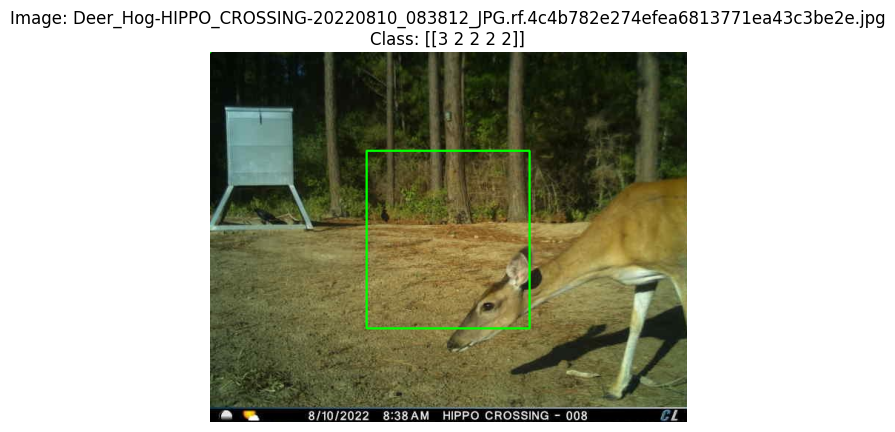

1/1 [==============================] - 0s 25ms/step


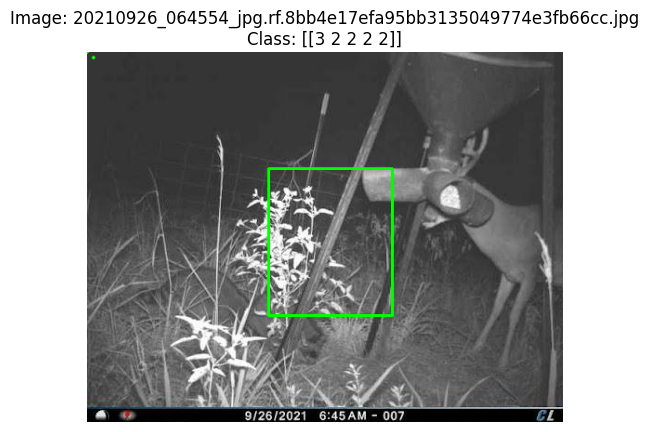

Error processing image 5ee28327-5bc8-4f1a-8c37-5ee32fde1fc3_jpg.rf.04f704cc55fb6b8e95f25885e7ffbe99.xml: cannot identify image file <_io.BytesIO object at 0x7ff106096de0>
1/1 [==============================] - 0s 51ms/step


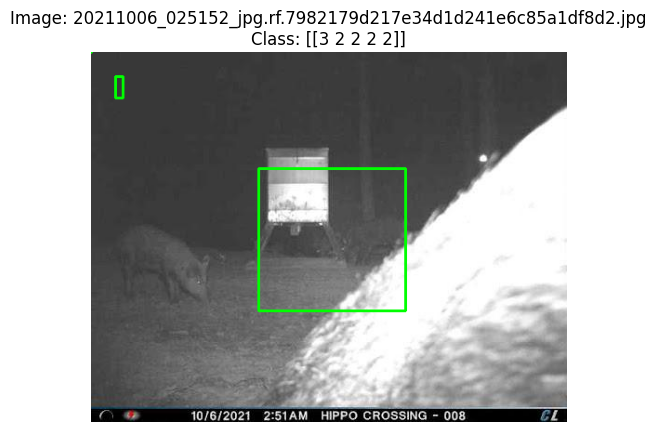

Error processing image da0fee18-758f-4d79-b70a-126db92e5b96_jpg.rf.0e45121b23d0bf1d1151f8a1e3e8041f.xml: cannot identify image file <_io.BytesIO object at 0x7ff106072c00>


In [18]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'EfficientNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")


1/1 [==============================] - 2s 2s/step


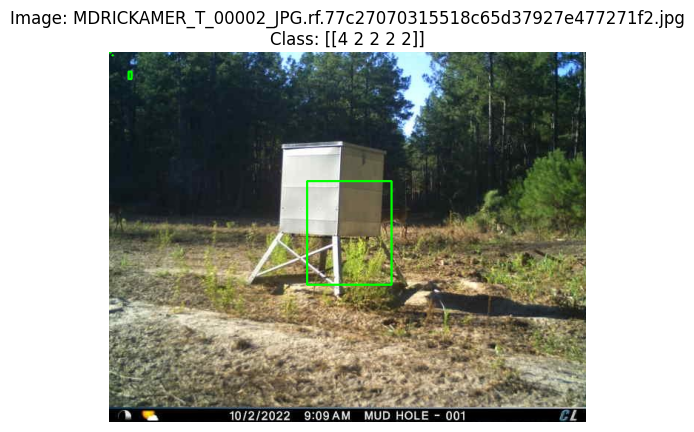

1/1 [==============================] - 0s 41ms/step


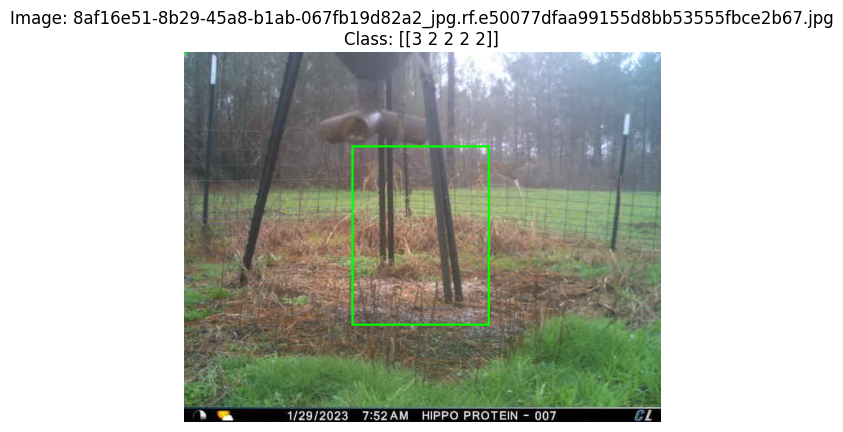

1/1 [==============================] - 0s 37ms/step


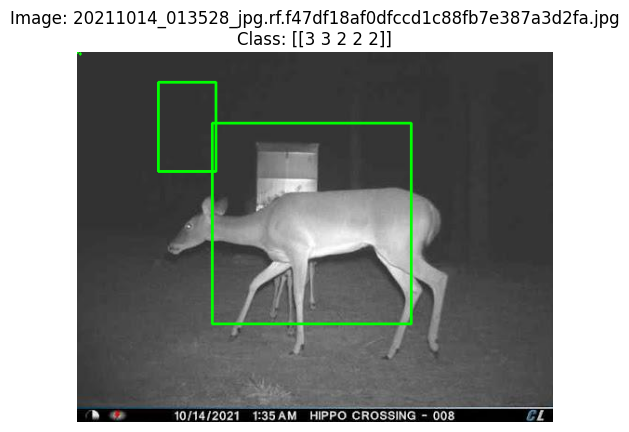

1/1 [==============================] - 0s 24ms/step


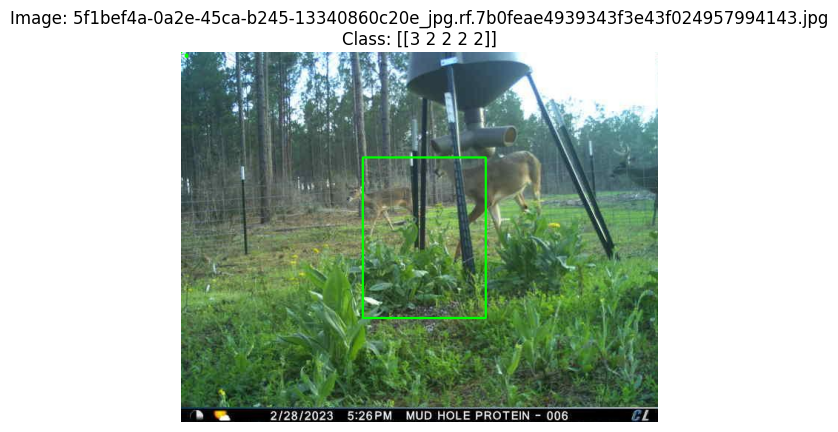

1/1 [==============================] - 0s 41ms/step


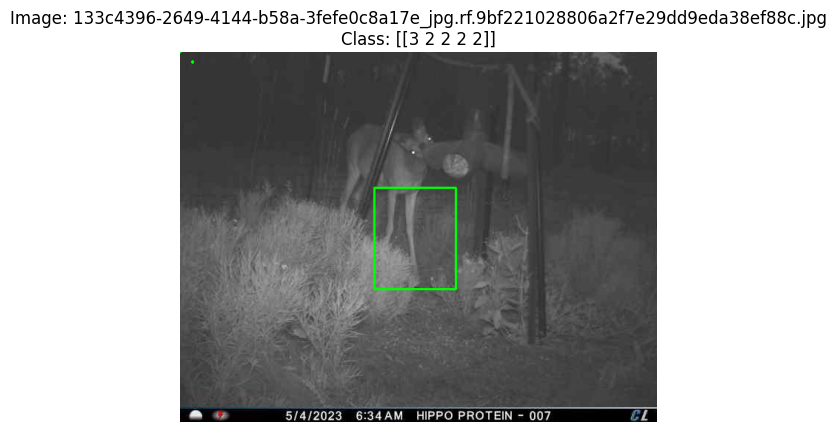

Error processing image e0f3d7a3-0de4-4f0e-8458-cb19f8d71a51_jpg.rf.c2f62c5bf5ed73cba6172ea5ddd139b0.xml: cannot identify image file <_io.BytesIO object at 0x7ff1051c0270>
1/1 [==============================] - 0s 24ms/step


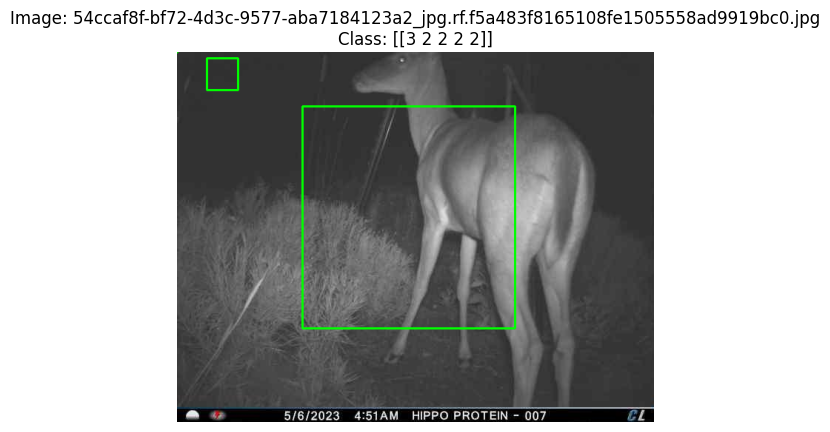

1/1 [==============================] - 0s 23ms/step


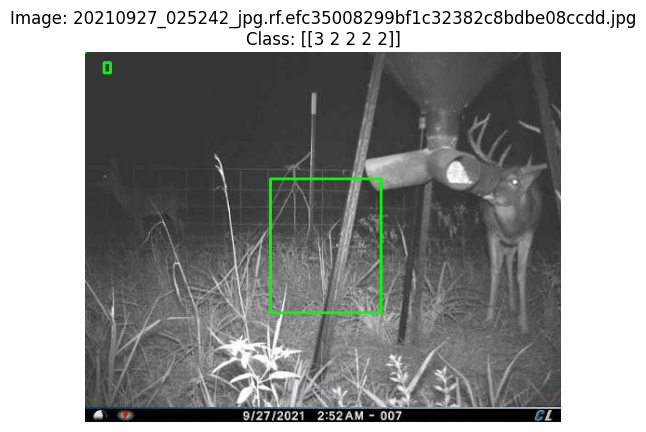

Error processing image I__00925_JPG_jpg.rf.8e83f2f97f215776d571f3e83c37e16f.xml: cannot identify image file <_io.BytesIO object at 0x7ff1050e2340>
1/1 [==============================] - 0s 26ms/step


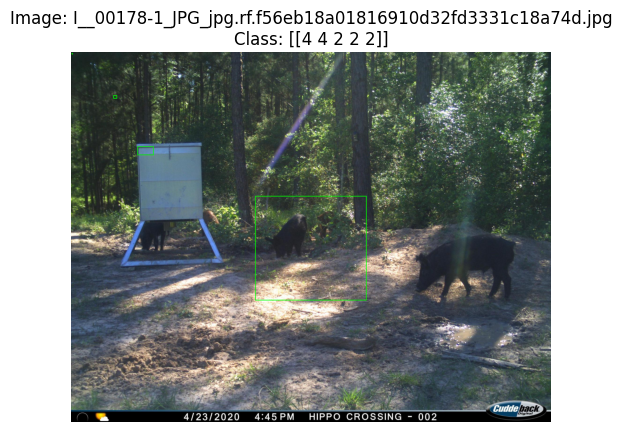

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'EfficientNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")


Error processing image I__00100-1_JPG_jpg.rf.6d5bb09376eb512d4990828cd8fc638b.xml: cannot identify image file <_io.BytesIO object at 0x7ff10509b240>
Error processing image 4f27c690-d7eb-4360-ac72-0fb7a50b84bf_jpg.rf.eb689c6e39754c5ad66633a1522d90b0.xml: cannot identify image file <_io.BytesIO object at 0x7ff1050d5df0>
Error processing image b4da059f-7fd5-4c6a-a998-bc76f12a80fc_jpg.rf.2e2ce439b8253deeb77cff32fc105185.xml: cannot identify image file <_io.BytesIO object at 0x7ff1050d5f80>
1/1 [==============================] - 2s 2s/step


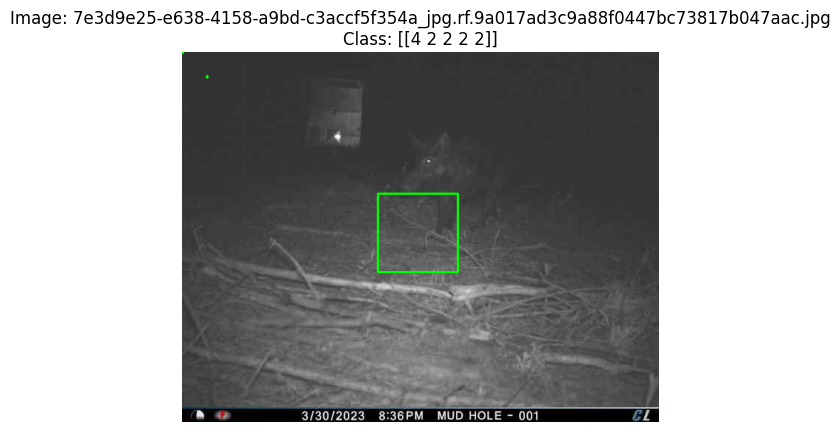

Error processing image 20210925_211338_jpg.rf.a0584658c15444d8da3c9e7e41354fad.xml: cannot identify image file <_io.BytesIO object at 0x7ff105cba3e0>
Error processing image 365a0c78-9f28-4b83-9ac1-81bdc7849aa0_jpg.rf.ef06859985419bf9b92af82dfc8aefac.xml: cannot identify image file <_io.BytesIO object at 0x7ff105cba3e0>
Error processing image 9b5775c7-b517-4b19-8bd6-d9d40c29cd23_jpg.rf.0662ceec71274fbbe49079bfee3a13b8.xml: cannot identify image file <_io.BytesIO object at 0x7ff105cba3e0>
1/1 [==============================] - 0s 45ms/step


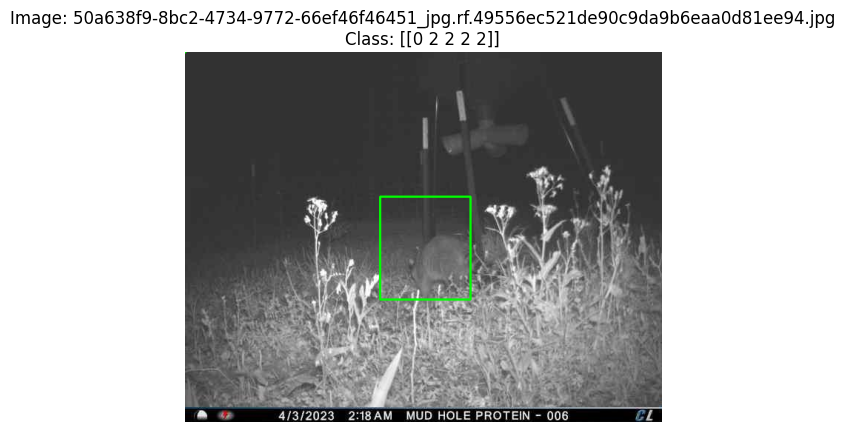

Error processing image coyote99_jpg.rf.04cdab931381afaff78b7d1a199366ca.xml: cannot identify image file <_io.BytesIO object at 0x7ff105c88090>
1/1 [==============================] - 0s 56ms/step


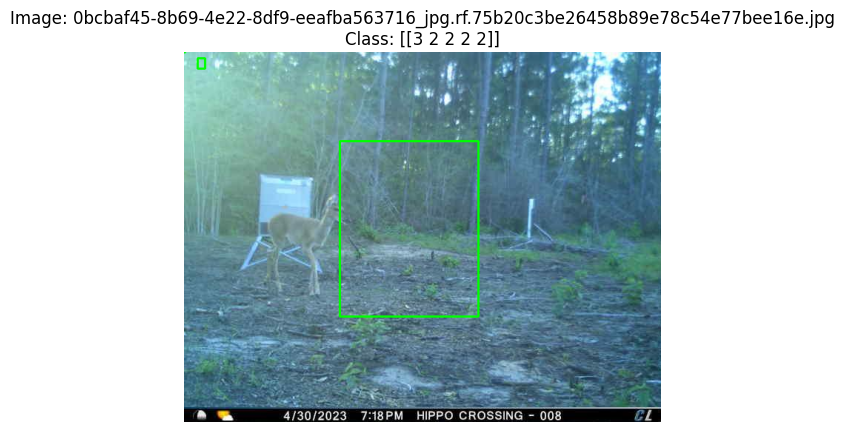

In [20]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'EfficientNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")


1/1 [==============================] - 1s 1s/step


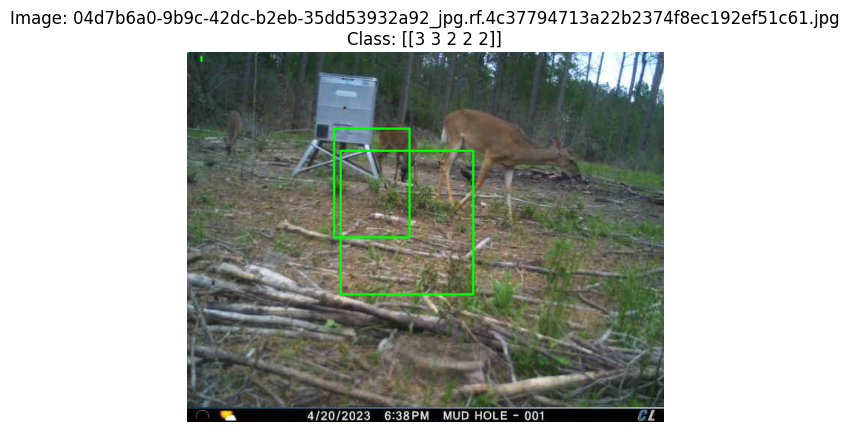

Error processing image 113da0a7-cc06-463b-8be8-77dd7c61926d_jpg.rf.d5b65eebf1aa738acd1acbd919ed2d9d.xml: cannot identify image file <_io.BytesIO object at 0x7ff105d96a70>
Error processing image 20210909_074852_jpg.rf.6c29f51d37e7d715024c32701b702e3e.xml: cannot identify image file <_io.BytesIO object at 0x7ff105d96a70>
Error processing image 20210923_204016_jpg.rf.f44ef1652fbba50c2cc2bd34722015bd.xml: cannot identify image file <_io.BytesIO object at 0x7ff105d96a70>
1/1 [==============================] - 0s 33ms/step


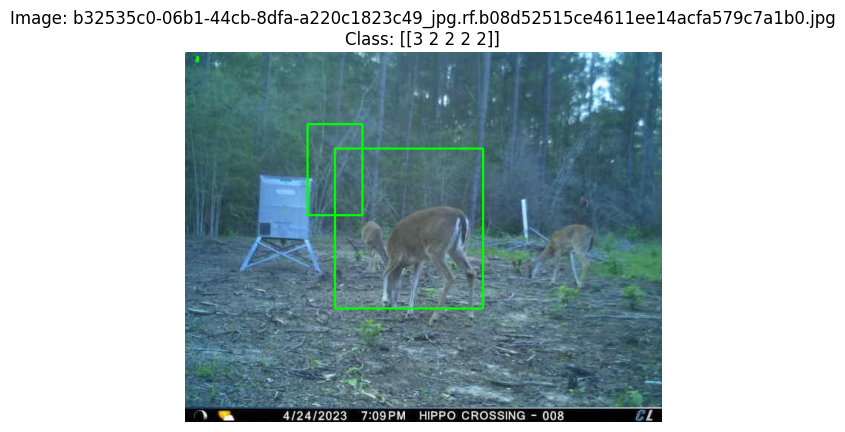

1/1 [==============================] - 0s 47ms/step


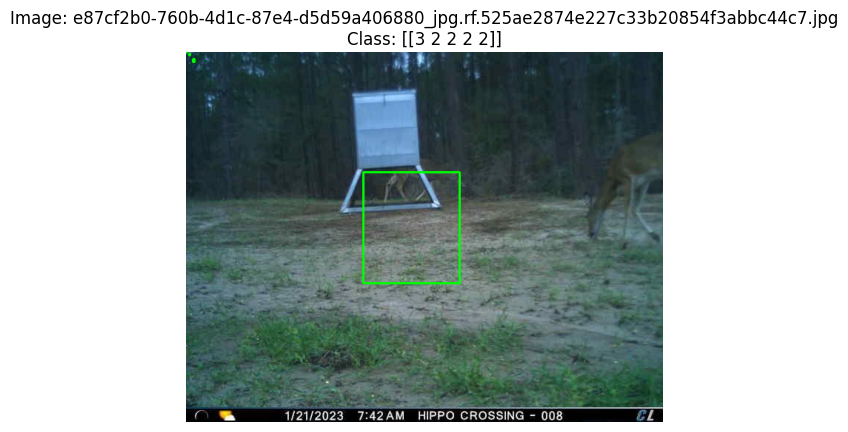

Error processing image c37a75c0-7c8c-42a2-9e66-43024b18a3be_jpg.rf.ec297c33ac8382658abeb38618239fa1.xml: cannot identify image file <_io.BytesIO object at 0x7ff10553ea70>
Error processing image 34d31d3e-f0a4-40d3-b09d-ea5f21142905_jpg.rf.0e7af4f643ff55e384d7fdd85ca17667.xml: cannot identify image file <_io.BytesIO object at 0x7ff10553ea70>
1/1 [==============================] - 0s 51ms/step


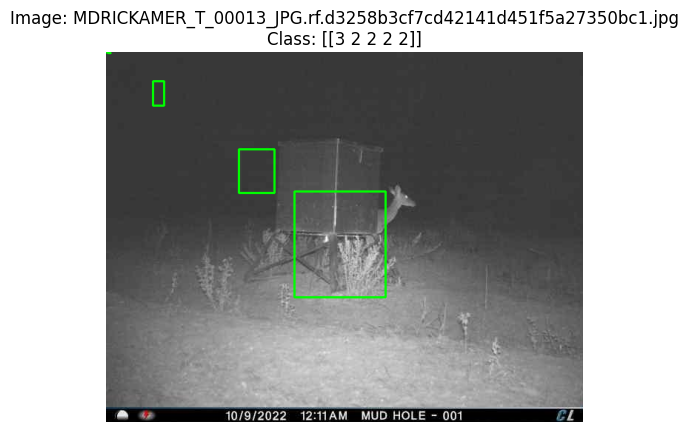

1/1 [==============================] - 0s 35ms/step


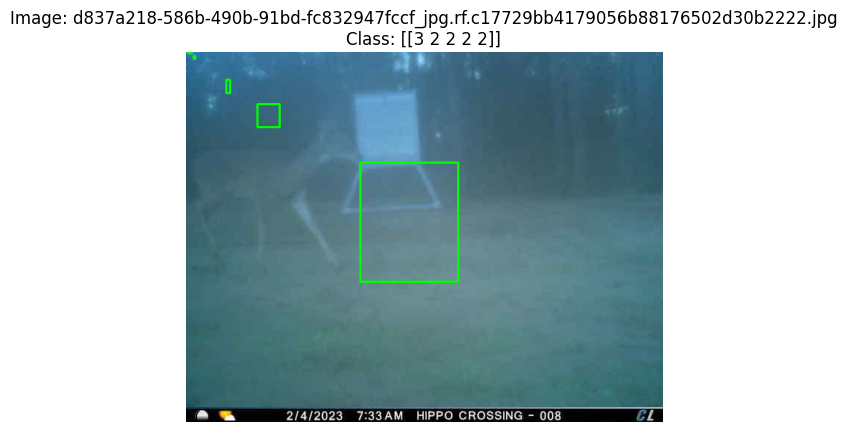

In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'EfficientNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")


Error processing image MDRICKAMER_T_00020_JPG.rf.d1dcc06999e00cff51ba792545471b77.xml: cannot identify image file <_io.BytesIO object at 0x7ff0f9cb3510>
1/1 [==============================] - 1s 1s/step


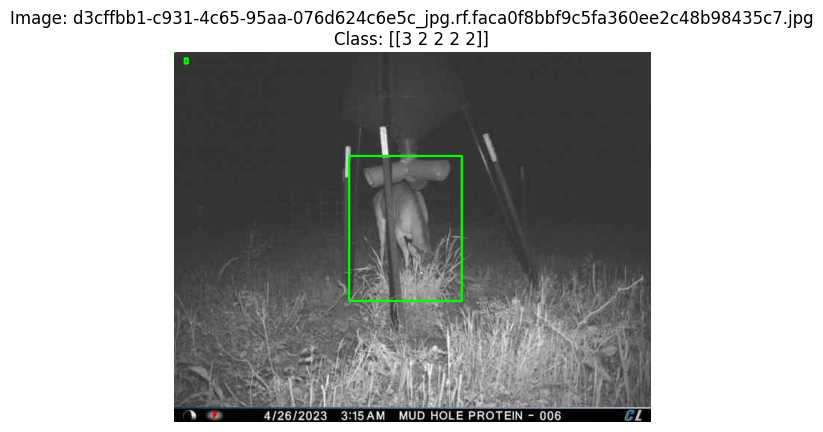

Error processing image 20210926_065004_jpg.rf.b5e63a01bf1e8b7bbccf4a3718ac6009.xml: cannot identify image file <_io.BytesIO object at 0x7ff0f9d8b830>
Error processing image 1663c469-d1a2-4175-93b0-692ed6c4991f_jpg.rf.115fddb6ac9f19bea339c2706d98381e.xml: cannot identify image file <_io.BytesIO object at 0x7ff0f9d8b830>
1/1 [==============================] - 0s 24ms/step


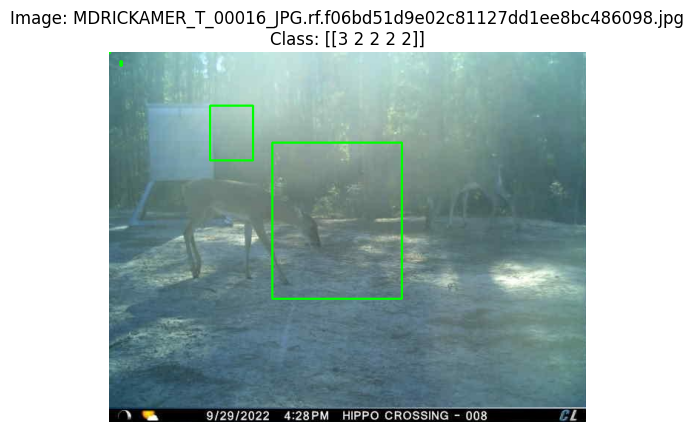

Error processing image 206_jpg.rf.d82c73eabd6af49eaa69dfac236fa4f5.xml: cannot identify image file <_io.BytesIO object at 0x7ff105e8f150>
1/1 [==============================] - 0s 25ms/step


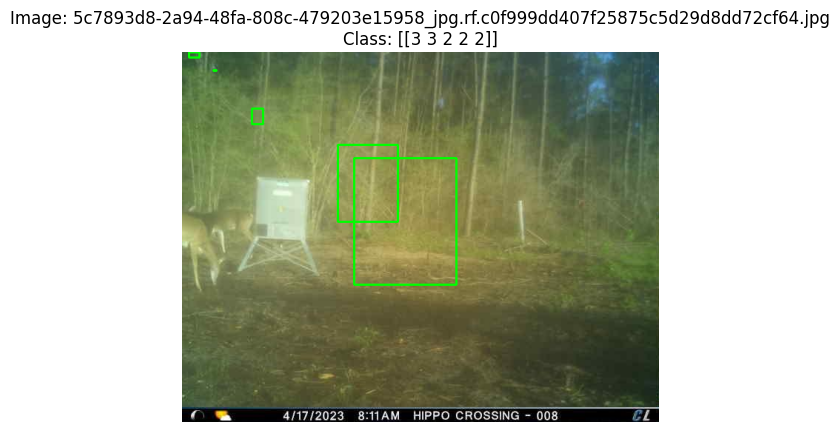

Error processing image 1c8cb98f-ec43-419d-b9ca-4dae1de15680_jpg.rf.d2762052b326c26d5547fd8b17ac5219.xml: cannot identify image file <_io.BytesIO object at 0x7ff105c61da0>
1/1 [==============================] - 0s 24ms/step


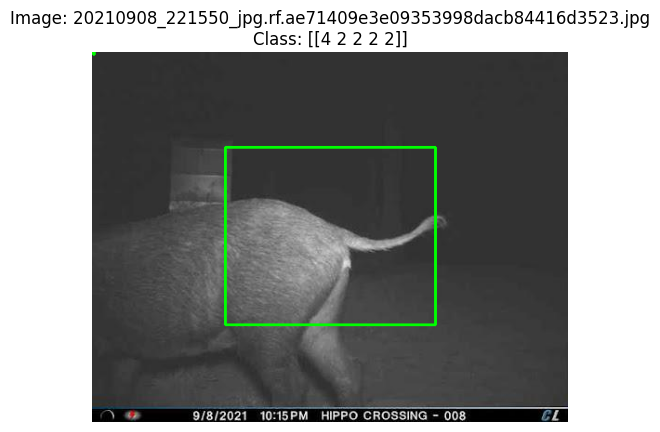

Error processing image ca4106bd-d3b4-4902-a862-e57b8b67cbe1_jpg.rf.0616b9cb7861c0164def7121ed640e98.xml: cannot identify image file <_io.BytesIO object at 0x7ff0f9ee8270>


In [26]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Load the saved model
model_path = 'EfficientNet_Backbone_object_detection_model.h5'
model = load_model(model_path)

# Path to the test images
test_images_path = '/content/gdrive/MyDrive/DL/My Game Pics.v5i.voc/test'

# Randomly select 10 images
selected_images = np.random.choice(os.listdir(test_images_path), size=10, replace=False)

# Iterate over selected images
for image_name in selected_images:
    try:
        # Load and preprocess the image
        img_path = os.path.join(test_images_path, image_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make predictions
        predictions = model.predict(img_array)

        # Extract classification and bounding box predictions
        classification_pred, bbox_pred = predictions

        # Post-process classification predictions
        classification_pred = np.argmax(classification_pred, axis=-1)

        # Post-process bounding box predictions
        # You might need to adjust the post-processing based on your specific implementation
        # This is a simple example assuming 5 bounding boxes
        bbox_pred = np.reshape(bbox_pred, (5, 4))

        # Visualize the results
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes on the image
        for bbox in bbox_pred:
            xmin, ymin, xmax, ymax = bbox
            xmin, ymin, xmax, ymax = int(xmin * img.shape[1]), int(ymin * img.shape[0]), int(xmax * img.shape[1]), int(ymax * img.shape[0])
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        # Display the image with predictions
        plt.imshow(img)
        plt.title(f"Image: {image_name}\nClass: {classification_pred}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image {image_name}: {str(e)}")
